## Урок 7. Тюнинг гиперпараметров, построение ансамблей алгоритмов.

In [1]:
# !pip install catboost

In [2]:
# !pip install --upgrade --force-reinstall --no-deps kaggle

In [85]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression

In [4]:
# !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle competitions download -c geekbrains-competitive-data-analysis

In [5]:
# !kaggle -v

In [6]:
# !unzip -q /content/geekbrains-competitive-data-analysis.zip -d /content/data

## Useful Functions

In [7]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "data"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=50,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=100,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


## Prepare data

In [8]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3
    # X["log_external_scoring_rating_1"] = np.log(X["external_scoring_rating_1"])
    # X["log_external_scoring_rating_2"] = np.log(X["external_scoring_rating_2"])
    # X["log_external_scoring_rating_3"] = np.log(X["external_scoring_rating_3"])

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]

    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    # X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    # X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    # X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    # X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    # X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    # X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]
    

    return X

def append_to_data(data: pd.DataFrame, X: pd.DataFrame, groupby: str="application_number"):
    X = X.replace(365243, np.nan)
    X = X.groupby(groupby).mean()

    data = data.merge(X, how="left", on=groupby)

    return data


train = get_input("train.csv")
test = get_input("test.csv")

data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)
client_profile.head(n=2)

data = data.merge(
    client_profile, how="left", on="application_number"
)
data.shape



train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols
client_profile.csv: shape = 250000 rows, 24 cols


/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


(275234, 49)

In [9]:
categorical = data.dtypes[data.dtypes == "object"].index
numerical = list(set(data.columns) - set(categorical))
data[numerical] = data[numerical].astype(float)
data[categorical] = data[categorical].astype('category')

data = pd.get_dummies(data)

mask = data["target"].isnull()
train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(["application_number", "target"], axis=1)
test = test.drop(["application_number", "target"], axis=1)
t_categorical = train.dtypes[train.dtypes == "object"].index
t_numerical = list(set(train.columns) - set(t_categorical))
data.head(3)

,application_number,target,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,total_salary_net,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,name_contract_type_Cash,name_contract_type_Credit Card,gender_F,gender_M,gender_XNA,education_level_Academic degree,education_level_Higher education,education_level_Incomplete higher,education_level_Lower secondary,education_level_Secondary / secondary special,family_status_Civil marriage,family_status_Married,family_status_Separated,family_status_Single / not married,family_status_Unknown,family_status_Widow
0,123687442.0,0.0,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,132372.0,1.59766,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
1,123597908.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,123526683.0,0.0,0.0,135000.0,1006920.0,42660.0,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,11.0,0.539379,NaN,NaN,0.267869,0.682149,0.475009,0.475009,0.042907,23.603376,0.316000,7.458667,92340.0,1.97894,46.709653,6.262467,37.313433,278.308458,11.791045,5.958264,3562.9200,NaN,NaN,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0


In [10]:
payments = get_input("payments.csv")

bki = get_input("bki.csv")

appl_history = get_input("applications_history.csv")

data = append_to_data(data, payments)
data = append_to_data(data, bki)
data = append_to_data(data, appl_history)

payments.csv: shape = 1023932 rows, 8 cols
bki.csv: shape = 945234 rows, 17 cols
applications_history.csv: shape = 1670214 rows, 26 cols


Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:

Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.


In [11]:
# n_estimators = 50
# early_stop = 50
# random_state = 42
# eta = 0.3

In [12]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 2000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    "early_stopping_rounds": 150,
    'silent': -1,
    'verbose': -1
}

lgbm_cv = KFold(n_splits=3, random_state=42, shuffle=True)

estimators, lgbm_oof = lightgbm_cross_validation(
    params=lgbm_params, X=train, y=target, cv=lgbm_cv
)

Sun Dec 20 10:50:40 2020, Cross-Validation, 110093 rows, 59 cols


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 150 rounds.
[50]	valid_0's auc: 0.720527	valid_0's binary_logloss: 0.269963
[100]	valid_0's auc: 0.72209	valid_0's binary_logloss: 0.264339
[150]	valid_0's auc: 0.723315	valid_0's binary_logloss: 0.260798
[200]	valid_0's auc: 0.724373	valid_0's binary_logloss: 0.258414
[250]	valid_0's auc: 0.725646	valid_0's binary_logloss: 0.256704
[300]	valid_0's auc: 0.726919	valid_0's binary_logloss: 0.255527
[350]	valid_0's auc: 0.727711	valid_0's binary_logloss: 0.25459
[400]	valid_0's auc: 0.72926	valid_0's binary_logloss: 0.253857
[450]	valid_0's auc: 0.730243	valid_0's binary_logloss: 0.253312
[500]	valid_0's auc: 0.73124	valid_0's binary_logloss: 0.252783
[550]	valid_0's auc: 0.733009	valid_0's binary_logloss: 0.252309
[600]	valid_0's auc: 0.734734	valid_0's binary_logloss: 0.251879
[650]	valid_0's auc: 0.736193	valid_0's binary_logloss: 0.251538
[700]	valid_0's auc: 0.736854	valid_0's binary_logloss: 0.25129
[750]	valid_0's auc: 0.73717	vali

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 150 rounds.
[50]	valid_0's auc: 0.712489	valid_0's binary_logloss: 0.269517
[100]	valid_0's auc: 0.7136	valid_0's binary_logloss: 0.264117
[150]	valid_0's auc: 0.714654	valid_0's binary_logloss: 0.260733
[200]	valid_0's auc: 0.716658	valid_0's binary_logloss: 0.258408
[250]	valid_0's auc: 0.718176	valid_0's binary_logloss: 0.256775
[300]	valid_0's auc: 0.719776	valid_0's binary_logloss: 0.255633
[350]	valid_0's auc: 0.721009	valid_0's binary_logloss: 0.254755
[400]	valid_0's auc: 0.722584	valid_0's binary_logloss: 0.254078
[450]	valid_0's auc: 0.72342	valid_0's binary_logloss: 0.253565
[500]	valid_0's auc: 0.724224	valid_0's binary_logloss: 0.253097
[550]	valid_0's auc: 0.725227	valid_0's binary_logloss: 0.252717
[600]	valid_0's auc: 0.726014	valid_0's binary_logloss: 0.252321
[650]	valid_0's auc: 0.727357	valid_0's binary_logloss: 0.252005
[700]	valid_0's auc: 0.727877	valid_0's binary_logloss: 0.251824
[750]	valid_0's auc: 0.728158	v

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 150 rounds.
[50]	valid_0's auc: 0.700915	valid_0's binary_logloss: 0.274587
[100]	valid_0's auc: 0.704376	valid_0's binary_logloss: 0.269412
[150]	valid_0's auc: 0.705954	valid_0's binary_logloss: 0.26622
[200]	valid_0's auc: 0.707237	valid_0's binary_logloss: 0.264176
[250]	valid_0's auc: 0.708576	valid_0's binary_logloss: 0.26276
[300]	valid_0's auc: 0.709975	valid_0's binary_logloss: 0.261796
[350]	valid_0's auc: 0.710632	valid_0's binary_logloss: 0.261062
[400]	valid_0's auc: 0.711411	valid_0's binary_logloss: 0.260518
[450]	valid_0's auc: 0.712454	valid_0's binary_logloss: 0.260037
[500]	valid_0's auc: 0.713611	valid_0's binary_logloss: 0.259576
[550]	valid_0's auc: 0.714148	valid_0's binary_logloss: 0.259278
[600]	valid_0's auc: 0.715515	valid_0's binary_logloss: 0.258999
[650]	valid_0's auc: 0.716846	valid_0's binary_logloss: 0.258709
[700]	valid_0's auc: 0.717666	valid_0's binary_logloss: 0.258533
[750]	valid_0's auc: 0.717991	

In [13]:
lgbm_oof_score = roc_auc_score(
    target, lgbm_oof
)
print(f"OOF-score = {round(lgbm_oof_score, 5)}")

OOF-score = 0.72813


In [14]:
y_pred_lgbm = np.zeros(test.shape[0])
test[t_numerical] = test[t_numerical].astype(float)
test[t_categorical] = test[t_categorical].astype(str)

for estimator in estimators:
    y_pred_lgbm += estimator.predict_proba(test)[:, 1]

In [15]:
y_pred_lgbm = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_lgbm / lgbm_cv.n_splits
})
y_pred_lgbm['APPLICATION_NUMBER'] = y_pred_lgbm['APPLICATION_NUMBER'].astype(int)
y_pred_lgbm.to_csv("baseline_submit_lgbm_II.csv", index=False)

In [16]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.03",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "early_stopping_rounds": 50,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=3, random_state=42, shuffle=True)


xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    params=xgb_params, X=train, y=target, cv=xgb_cv
)


Sun Dec 20 10:53:30 2020, Cross-Validation, 110093 rows, 59 cols
[0]	train-auc:0.687384	valid-auc:0.692374
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.724975	valid-auc:0.722993
[200]	train-auc:0.742592	valid-auc:0.733694
[300]	train-auc:0.750005	valid-auc:0.736228
[400]	train-auc:0.755457	valid-auc:0.737161
[500]	train-auc:0.759203	valid-auc:0.737892
[600]	train-auc:0.762258	valid-auc:0.738687
[700]	train-auc:0.765303	valid-auc:0.738623
Stopping. Best iteration:
[682]	train-auc:0.765139	valid-auc:0.738911

Fold 1, Valid score = 0.7386
[0]	train-auc:0.692112	valid-auc:0.687802
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.728063	valid-auc:0.714892
[200]	train-auc:0.746502	valid-auc:0.724976
[300]	train-auc:0.754284	valid-auc:0.727289
[400]	train-auc:0.759657	

In [17]:
xgb_oof_score = roc_auc_score(
    target, xgb_oof
)
print(f"OOF-score = {round(xgb_oof_score, 5)}")

OOF-score = 0.72854


In [20]:
y_pred_xgb = np.zeros(test.shape[0])
test[t_numerical] = test[t_numerical].astype(float)
test[t_categorical] = test[t_categorical].astype(str)

dtest = xgb.DMatrix(data=test)

for estimator in xgb_estimators:
    y_pred_xgb += estimator.predict(dtest)


y_pred_xgb = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_xgb / xgb_cv.n_splits
})
y_pred_xgb["APPLICATION_NUMBER"] = y_pred_xgb["APPLICATION_NUMBER"].astype(int)
y_pred_xgb.to_csv("baseline_submit_xgb_II.csv", index=False)

In [21]:
scores = pd.DataFrame({
    "lgbm": lgbm_oof,
    "xgb": xgb_oof,
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

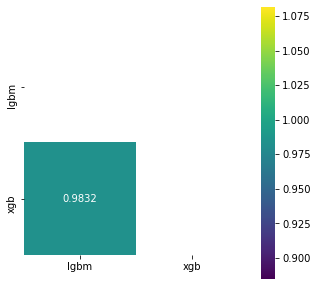

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [43]:
scores_test = pd.DataFrame({
    "lgbm": y_pred_lgbm["TARGET"],
    "xgb": y_pred_xgb["TARGET"],
    
})

corr_test = scores_test.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

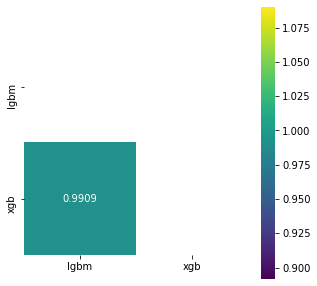

In [44]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr_test, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Корреляция на train хорошая, на test нет

2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [27]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7288


In [28]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7289


In [29]:
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7288


In [30]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7289


Все комбинации немного прибавили качество.      
И, как говорил сенсей, геометрическая средняя всегда не хуже арифметической :)

3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.


In [31]:
cb_params = {
    "n_estimators": 3000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 50,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 20,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42,
    # "silent": True
}

cb_cv = KFold(n_splits=3, random_state=42, shuffle=True)

estimators, cb_oof = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=cb_cv, categorical=t_categorical
)

Sun Dec 20 11:03:00 2020, Cross-Validation, 110093 rows, 59 cols
0:	test: 0.6562826	test1: 0.6512537	best: 0.6512537 (0)	total: 126ms	remaining: 6m 18s
100:	test: 0.7086075	test1: 0.7174084	best: 0.7175099 (98)	total: 6.62s	remaining: 3m 9s
200:	test: 0.7131397	test1: 0.7203592	best: 0.7205599 (190)	total: 13.1s	remaining: 3m 2s
300:	test: 0.7190821	test1: 0.7236225	best: 0.7236300 (299)	total: 19.8s	remaining: 2m 57s
400:	test: 0.7246805	test1: 0.7265222	best: 0.7265891 (399)	total: 26.6s	remaining: 2m 52s
500:	test: 0.7291528	test1: 0.7293795	best: 0.7294582 (499)	total: 33.4s	remaining: 2m 46s
600:	test: 0.7328196	test1: 0.7309307	best: 0.7309560 (599)	total: 40.2s	remaining: 2m 40s
700:	test: 0.7358540	test1: 0.7319456	best: 0.7319654 (697)	total: 46.8s	remaining: 2m 33s
800:	test: 0.7389321	test1: 0.7323354	best: 0.7324911 (769)	total: 53.2s	remaining: 2m 26s
900:	test: 0.7419433	test1: 0.7337636	best: 0.7337636 (900)	total: 59.8s	remaining: 2m 19s
Stopped by overfitting detector 

In [32]:
oof_score = roc_auc_score(
    target, cb_oof
)
print(f"OOF-score = {round(oof_score, 5)}")

OOF-score = 0.7243


In [33]:
y_pred_cb = np.zeros(test.shape[0])
test[t_numerical] = test[t_numerical].astype(float)
test[t_categorical] = test[t_categorical].astype(str)

for estimator in estimators:
    y_pred_cb += estimator.predict_proba(test)[:, 1]

In [34]:
y_pred_cb = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_cb / lgbm_cv.n_splits
})
y_pred_cb['APPLICATION_NUMBER'] = y_pred_cb['APPLICATION_NUMBER'].astype(int)
y_pred_cb.to_csv("baseline_submit_cb_II.csv", index=False)

In [35]:
scores = pd.DataFrame({
    "lgbm": lgbm_oof,
    "xgb": xgb_oof,
    "cb": cb_oof
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

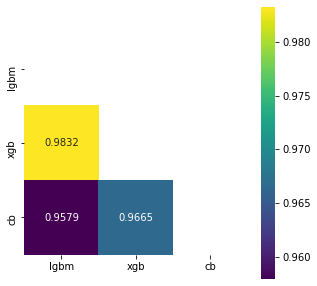

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [59]:
scores_test_1 = pd.DataFrame({
    "lgbm": y_pred_lgbm["TARGET"],
    "xgb": y_pred_xgb["TARGET"],
    "cb": y_pred_cb["TARGET"]
    
})

corr_test_1 = scores_test_1.corr()
mask = np.zeros_like(corr_test_1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

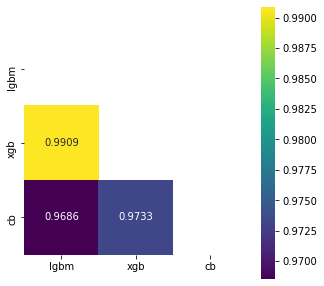

In [60]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr_test_1, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

4. Выполнить задание 2 для трех моделей.


In [37]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7285


In [38]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7286


In [39]:
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7284


In [40]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7285


Качество комбинаций немного упало по отношению к предыдущим. Все комбинации примерно на уровне XGBoost. Геометрическая средняя опять лучше

5. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

In [82]:
all_oof = pd.DataFrame()
all_oof["lgbm"] = lgbm_oof
all_oof["xgb_oof"] = xgb_oof
all_oof["cb_oof"] = cb_oof


In [86]:
model_lr = LogisticRegression().fit(all_oof, target)
y_pred_lr = model_lr.predict_proba(all_oof)[:, 1]
roc_auc_score(target, y_pred_lr)

0.7286677914140807

Качество лучше было только во втором пункте

6. (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

